In [1]:
# # Import PyDrive and associated libraries.
# # This only needs to be done once in a notebook.
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# Create & upload a text file.
# uploaded = drive.CreateFile({'title': 'Sample file.txt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import PIL
from PIL import Image, ImageOps
from keras.preprocessing.image import img_to_array

In [2]:
def gen_image(arr):
    h, w = arr.shape[0], arr.shape[1]
    two_d = (np.reshape(arr, (h, w)) * 255).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img

In [3]:
def to_image(arr):
    h, w = arr.shape[0], arr.shape[1]
    two_d = np.reshape(arr, (h, w)).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img

In [4]:
def plot_dist(arr):
    n, m = arr.shape[0], arr.shape[1]
    flat = arr.reshape(np.prod(arr.shape))
    plt.hist(flat)

In [5]:
def center(arr):
    """
    from (0,255) to (-1, 1)
    """
    return (np.array(arr).astype(np.float32) -127.5)/ 127.5

In [6]:
def uncenter(arr):
    """
    from (-1, 1) back to (0, 255)
    """
    return (np.array(arr)+1)*127.5

In [7]:
import pickle
X_7__rotated_resized = np.array(pickle.load(open('./drive/MyDrive/X_7_rotated_resized.pickle', 'rb'))) # (0, 255)
X_7_resizings = np.array(pickle.load(open('./drive/MyDrive/X_7_resizings.pickle', 'rb'))) # range(-10, 10)
X_7_rotations = np.array(pickle.load(open('./drive/MyDrive/X_7_rotations.pickle', 'rb'))) # range(-90, 90)

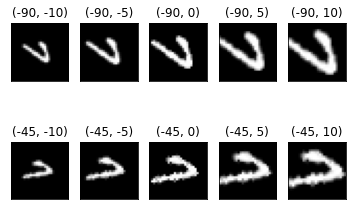

In [8]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    im = uncenter(X_7__rotated_resized[i])
    img = to_image(im)
    plt.imshow(img, cmap='gray')
    plt.title((X_7_rotations[i],X_7_resizings[i]))
    plt.xticks([])
    plt.yticks([])

In [9]:
# Try different conditioning method
class CGAN_rotate_resize():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        #self.num_classes = 10
        self.latent_dim = 100
        self.X_train = np.array(X_7__rotated_resized)  # assume (-1, 1)
        self.y_rotations = np.array(X_7_rotations)
        self.y_resizings = np.array(X_7_resizings)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        cond = Input(shape=(1,))
        cond1 = Input(shape=(1,))
        img = self.generator([noise, cond, cond1])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, cond, cond1])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, cond, cond1], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim+1+1)) # adding dim for cond, cond1
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        cond = Input(shape=(1,), dtype='float32')
        cond1 = Input(shape=(1,), dtype='float32')
        #cond_embedding = Flatten()(Embedding(1, self.latent_dim)(cond))

        #model_input = multiply([noise, label_embedding])
        model_input = concatenate([noise, cond, cond1])
        img = model(model_input)

        return Model([noise, cond, cond1], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)+1+1)) # adding dim for cond, cond1
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        cond = Input(shape=(1,), dtype='float32')
        cond1 = Input(shape=(1,), dtype='float32')

        #label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = concatenate([flat_img, cond, cond1])

        validity = model(model_input)

        return Model([img, cond, cond1], validity)

    def train(self, epochs=5000, batch_size=64, sample_interval=1000):

        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()
        # Use only '7' for this test
        (X_train, y_train, y_train1) = (self.X_train, self.y_rotations, self.y_resizings)

        # Configure input
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)
        y_train1 = y_train1.reshape(-1,1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, conds, conds1 = X_train[idx], y_train[idx], y_train1[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, conds, conds1])

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([imgs, conds, conds1], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, conds, conds1], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on conds
            sampled_conds = np.random.choice(self.y_rotations, batch_size)
            sampled_conds1 = np.random.choice(self.y_resizings, batch_size)

            # Train the generator
            self.discriminator.trainable = False
            g_loss = self.combined.train_on_batch([noise, sampled_conds, sampled_conds1], valid)

            # Plot the progress
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch, sampled_conds = self.y_rotations[:10], sampled_conds1 = self.y_resizings[:10])

    def sample_images(self, epoch, sampled_conds = None, sampled_conds1 = None):
        
        if sampled_conds.any == None:
            sampled_conds = self.y_rotations[:10].reshape(-1, 1)
            sampled_conds1 = self.y_resizings[:10].reshape(-1, 1)
            r, c = 2, 5
        else:
            r, c = 2, int(len(sampled_conds)//2)
            sampled_conds = np.array(sampled_conds)[:10].reshape(-1, 1)
            sampled_conds1 = np.array(sampled_conds1)[:10].reshape(-1, 1)

        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict([noise, sampled_conds, sampled_conds1])

        # Rescale images 0 - 255
        gen_imgs = uncenter(gen_imgs)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title((sampled_conds[cnt][0], sampled_conds1[cnt][0]))
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./%d.png" % epoch)
        plt.show()
        plt.close()


# if __name__ == '__main__':
#     cgan = CGAN()
#     cgan.train(epochs=20000, batch_size=32, sample_interval=200)

In [28]:
#(X_train, y_train), (_, _) = mnist.load_data()
# X_train = (X_train.astype(np.float32) - 127.5) / 127.5
# X_train = np.expand_dims(X_train, axis=3)
# y_train = y_train.reshape(-1, 1)

In [10]:
cgan_rotate_resize = CGAN_rotate_resize()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               402944    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

In [13]:
cgan_rotate_resize.X_train.shape

(156625, 28, 28)

0 [D loss: 0.328528, acc.: 86.72%] [G loss: 2.404079]


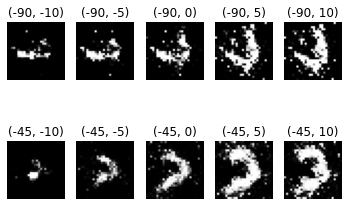

1000 [D loss: 0.445422, acc.: 77.34%] [G loss: 2.106729]


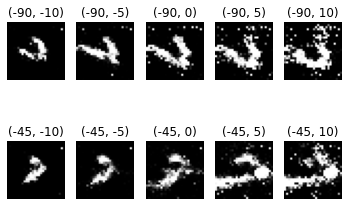

2000 [D loss: 0.485861, acc.: 74.22%] [G loss: 1.514382]


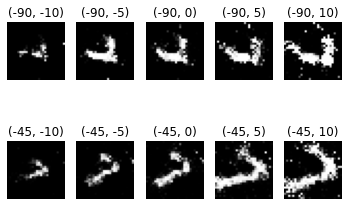

3000 [D loss: 0.417012, acc.: 80.47%] [G loss: 1.936930]


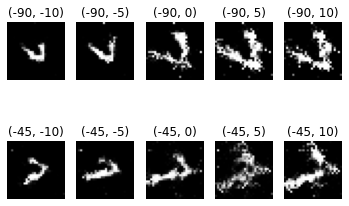

4000 [D loss: 0.585457, acc.: 71.09%] [G loss: 1.231868]


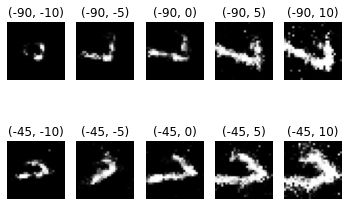

5000 [D loss: 0.535554, acc.: 68.75%] [G loss: 1.331807]


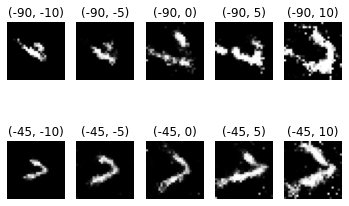

6000 [D loss: 0.560430, acc.: 71.88%] [G loss: 1.147300]


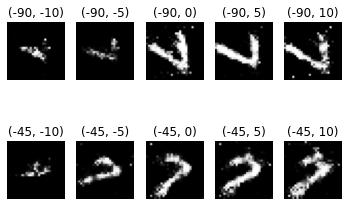

7000 [D loss: 0.603227, acc.: 64.84%] [G loss: 1.115149]


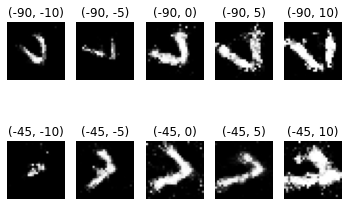

8000 [D loss: 0.695567, acc.: 54.69%] [G loss: 0.984260]


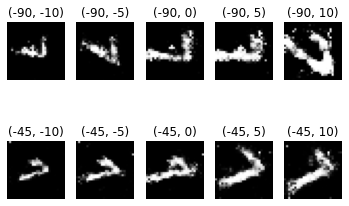

9000 [D loss: 0.618897, acc.: 61.72%] [G loss: 1.007886]


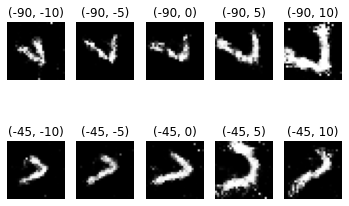

In [12]:
cgan_rotate_resize.train(epochs=10000, batch_size=64, sample_interval=1000)

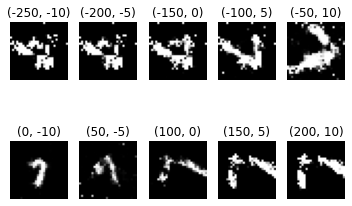

In [20]:
cgan_rotate_resize.sample_images(0, np.array([i*50 for i in range(-5,6)]), np.array(X_7_resizings[:10]))

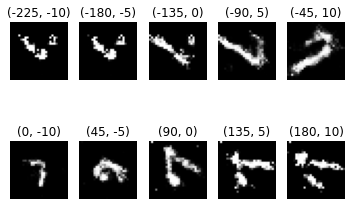

In [40]:
cgan_rotate_resize.sample_images(1, np.array([i*45 for i in range(-5,6)]), np.array(X_7_resizings[:10]))

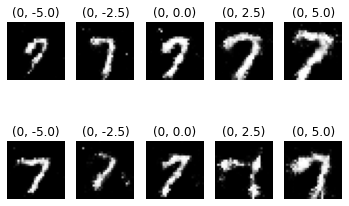

In [34]:
cgan_rotate_resize.sample_images(2, np.array([i*0 for i in range(-5,6)]), np.array(X_7_resizings[:10]/2))

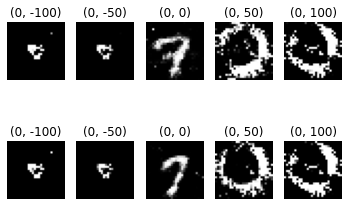

In [37]:
cgan_rotate_resize.sample_images(3, np.array([i*0 for i in range(-5,6)]), np.array(X_7_resizings[:10]*10))

In [29]:
# Zero-shot
cgan_rotate_resize.sample_images(0,sampled_conds=np.array([i*3 for i in range(-5,5)]))  #none of these angles are seen during the training

IndexError: ignored

#Discussion on Result
The number of iteration needed to reach equivalent qulity of sample incresed substantially. Though this is much less than what it took for dig+rotation experiement, and this is an interesting observation.  
Since this experiment was done using Concatenation method only, it is possible that the model just remember each combinations of conditions as separate class as opposed to treating the two as two separate conditions.   
In order to test this hypothesis, we now test the 

```
model_input = concatenate([flat_img, cond, cond1])
```

We will now 
